### 4.1

![4.1 Flowchart](./bin/markdownImages/q4.1.jpg)

### Explanation:
Firstly, to apply PCA, we change the data from a 2D image to a (NX2) vector where the two dimensions represent X and Y. <br> 
First we get angle (=theta1) by which template image is rotated from the original x and y axes by taking angle between the obtained PCA axes and the original x and y axes. The PCA axes give us the rotated coordinate axes because we choose the first 2 PC's which give us the two orthogonal directions of maximum, and second maximum variance, which can be considered as two axes along length and breadth of the object. <br>
Similarly, we get the angle between input image and the original x,y axes = theta2 <br>
Now, to make the input image's orientation = template image, we rotate the second image by theta = theta1 - theta2

In [1]:
import os
import numpy as np
imagesDir = "./bin/q4/KIMIA dataset/" 
templateName = "f15.png"
templatePath = imagesDir + templateName
tempList = os.listdir(imagesDir)
imagePaths = []
for i in range(len(tempList)):
    if (tempList[i] != templateName):
        imagePaths.append(imagesDir+tempList[i])
imagePaths = np.array(imagePaths)

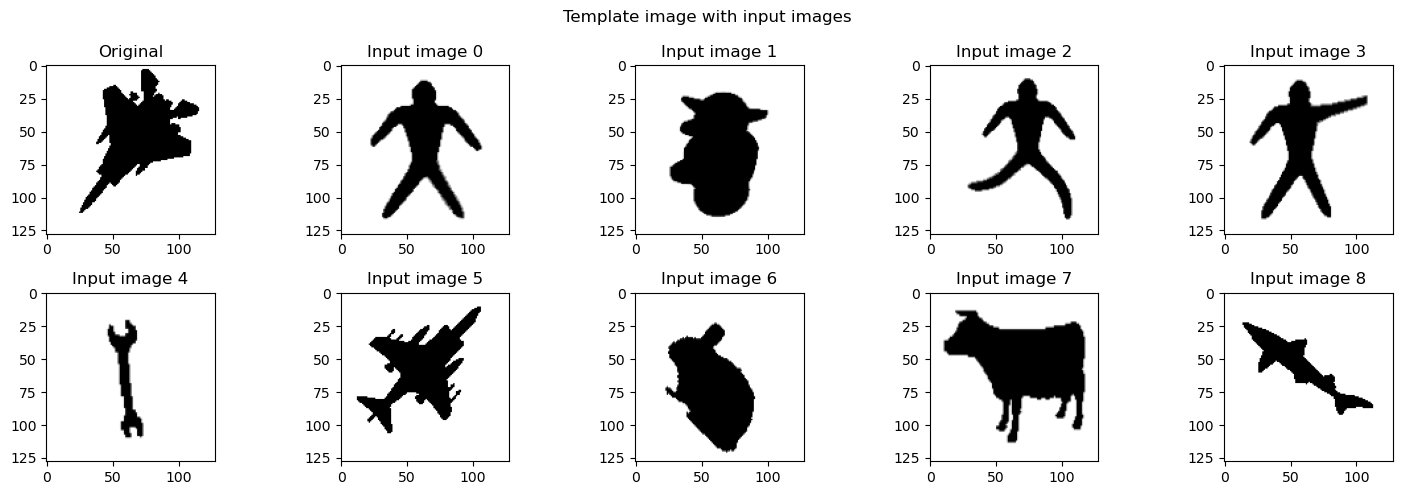

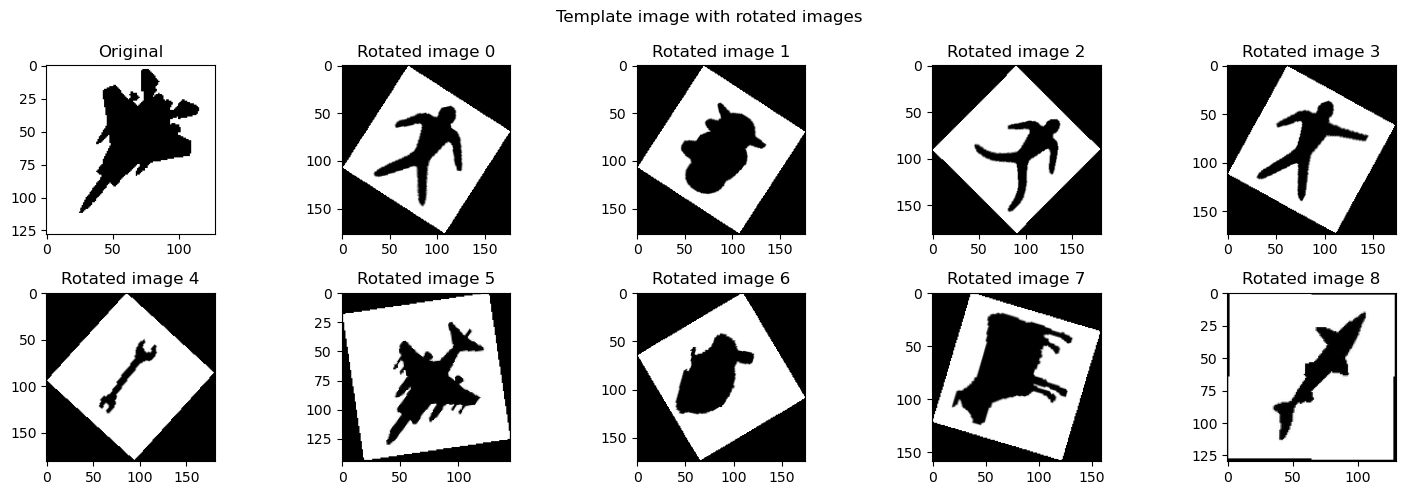

In [2]:
from scipy import ndimage
import cv2
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def rotate_PCA(templatePath, imagePaths: list):

    template = cv2.imread(templatePath,cv2.IMREAD_GRAYSCALE)

    images = []
    for i in imagePaths[np.random.choice(len(imagePaths)-1,9)]:
        images.append(cv2.resize(cv2.imread(i,cv2.IMREAD_GRAYSCALE),(template.shape)))

    c, r = np.where(template==0)
    X = np.array([c,r]).T
    pca = PCA(n_components=2)
    projected = pca.fit_transform(X)
    angle1 = np.arctan2(pca.components_[0,1], pca.components_[0,0])
    angle1 = np.degrees(angle1)

    plt.figure(figsize=(15,5))
    plt.subplot(2,5,1)
    plt.imshow(template, cmap="gray")
    plt.title('Original')
    for i in range(9):
        plt.subplot(2,5,i+2)
        plt.imshow(images[i], cmap = 'gray')
        plt.title(f'Input image {i}')
    plt.suptitle("Template image with input images")
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15,5))
    plt.subplot(2,5,1)
    plt.imshow(template, cmap="gray")
    plt.title('Original')

    for i in range(len(images)):
        c, r = np.where(images[i]==0)
        X = np.array([c,r]).T
        pca = PCA(n_components=2)
        projected = pca.fit_transform(X)
        angle2 = np.arctan2(pca.components_[0,1], pca.components_[0,0])
        angle2 = np.degrees(angle2)

        angle = angle1-angle2
        rotated = ndimage.rotate(images[i], angle)

        plt.subplot(2,5,i+2)
        plt.imshow(rotated, cmap = 'gray')
        plt.title(f'Rotated image {i}')

    plt.suptitle("Template image with rotated images")
    plt.tight_layout()
    plt.show()

rotate_PCA(templatePath,imagePaths)

### 4.2

In [3]:
import pandas as pd
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def visualize_bboxes(df, img):
  img_2 = img.copy()
  for index, rows in df.iterrows():
    top_left = (int(rows['Top-Left'].split(',')[0][1:]),int(rows['Top-Left'].split(',')[1][:-1]))
    bottom_right = (int(rows['Bottom-Right'].split(',')[0][1:]),int(rows['Bottom-Right'].split(',')[1][:-1]))
    print(top_left)
    cv2.rectangle(img_2, top_left, bottom_right, (255, 0, 0), 2)

    plt.imshow(img_2)

In [21]:
def make_connections(euclidean, image):

  image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  image_with_boxes = image_rgb.copy()

  for index, row in euclidean.iterrows():
      left = int(row['Left'][0])
      right = int(row['Right'][0])
      top = int(row['Top'][1])
      bottom = int(row['Bottom'][1])
      box_id = int(row['Id'])

      width = right - left
      height = bottom - top

      top_left = (left, top)
      bottom_right = (right, bottom)

      cv2.rectangle(image_with_boxes, top_left, bottom_right, (255, 0, 0), 2)

      label_position = (left, top - 10)
      cv2.putText(image_with_boxes, str(box_id), label_position, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

      top_adjacent_id = int(row['Top_Box'][1])
      bottom_adjacent_id = int(row['Bottom_Box'][1])
      left_adjacent_id = int(row['Left_Box'][1])
      right_adjacent_id = int(row['Right_Box'][1])

      if top_adjacent_id != 0:
          top_adjacent_row = euclidean[euclidean['Id'] == top_adjacent_id].iloc[0]
          top_adjacent_center = int(top_adjacent_row['Bottom'][0]) , int(top_adjacent_row['Bottom'][1])
          cv2.line(image_with_boxes, (int(left) + width // 2, int(top)), top_adjacent_center, (0, 255, 0), 2)

      if bottom_adjacent_id != 0:
          bottom_adjacent_row = euclidean[euclidean['Id'] == bottom_adjacent_id].iloc[0]
          bottom_adjacent_center = int(bottom_adjacent_row['Top'][0]) , int(bottom_adjacent_row['Top'][1])
          cv2.line(image_with_boxes, (int(left) + width // 2, int(bottom)), (int(bottom_adjacent_center[0]), int(bottom_adjacent_center[1])), (0, 255, 0), 2)

      if left_adjacent_id != 0:
          left_adjacent_row = euclidean[euclidean['Id'] == left_adjacent_id].iloc[0]
          left_adjacent_center = int(left_adjacent_row['Right'][0]) , int(left_adjacent_row['Right'][1])
          cv2.line(image_with_boxes, (int(left), int(top) + height // 2), (int(left_adjacent_center[0]), int(left_adjacent_center[1])), (0, 255, 0), 2)

      if right_adjacent_id != 0:
          right_adjacent_row = euclidean[euclidean['Id'] == right_adjacent_id].iloc[0]
          right_adjacent_center = int(right_adjacent_row['Left'][0]) , int(right_adjacent_row['Left'][1])
          cv2.line(image_with_boxes, (int(right), int(top) + height // 2), (int(right_adjacent_center[0]), int(right_adjacent_center[1])), (0, 255, 0), 2)

  return image_with_boxes

In [22]:
# Data pre processing
df = pd.read_csv("./bin/q4/SMAI - AQ2/CSV/TLBR_159.csv")
img = cv2.imread('./bin/q4/SMAI - AQ2/images/159.jpg')

coordinatesDF = pd.DataFrame.copy(df.iloc[:,1:3])
idsDF = pd.DataFrame.copy(df.iloc[:,:1])

coordinatesTemp = coordinatesDF.to_numpy()
ids = idsDF.to_numpy()
N = len(coordinatesTemp)
Coords = []
for i in range(N):
    topLeft = np.array([int(i) for i in coordinatesTemp[i][0][1:-1].split(", ")])
    bottomRight = np.array([int(i) for i in coordinatesTemp[i][1][1:-1].split(", ")])
    Coords.append(np.array([topLeft,bottomRight]))
Coords = np.array(Coords)
print(Coords.shape)

(129, 2, 2)


(365, 291)
(802, 284)
(873, 291)
(1972, 280)
(363, 455)
(570, 458)
(1027, 455)
(1148, 451)
(1269, 461)
(568, 571)
(701, 561)
(940, 564)
(1218, 564)
(1955, 561)
(568, 725)
(744, 728)
(974, 725)
(1245, 728)
(1491, 725)
(1557, 721)
(1905, 708)
(370, 827)
(720, 824)
(1279, 827)
(1419, 827)
(1658, 820)
(1864, 820)
(367, 930)
(713, 930)
(1153, 930)
(1494, 926)
(365, 1032)
(858, 1032)
(1165, 1025)
(568, 1189)
(674, 1186)
(979, 1179)
(1370, 1183)
(1726, 1183)
(1943, 1176)
(367, 1285)
(580, 1282)
(752, 1295)
(817, 1289)
(1042, 1289)
(1344, 1285)
(1474, 1282)
(1784, 1282)
(363, 1384)
(454, 1377)
(553, 1384)
(1951, 1384)
(363, 1531)
(570, 1538)
(1022, 1538)
(1211, 1535)
(566, 1644)
(670, 1651)
(1020, 1641)
(1204, 1641)
(1948, 1644)
(568, 1801)
(711, 1798)
(1223, 1794)
(1344, 1798)
(1602, 1798)
(1825, 1798)
(365, 1900)
(972, 1900)
(1426, 1900)
(1728, 1897)
(365, 2003)
(551, 2003)
(1117, 1996)
(1682, 1996)
(365, 2099)
(798, 2099)
(566, 2266)
(674, 2252)
(926, 2249)
(1090, 2246)
(1288, 2249)
(1491, 

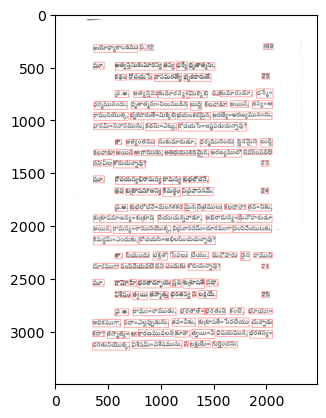

In [7]:
visualize_bboxes(df,img)

In [23]:
def calcCentres(coordinates):
    centres = np.zeros(coordinates[:,1].shape)
    centres[:,0] = (coordinates[:,0,0] + coordinates[:,1,0])//2
    centres[:,1] = (coordinates[:,0,1] + coordinates[:,1,1])//2
    return centres

In [24]:
centres = calcCentres(coordinates=Coords)

In [55]:
from sklearn.metrics import pairwise_distances
def horiDist(p1,p2):
    return abs(p1[0]-p2[0])
def vertDist(p1,p2):
    return abs(p1[1]-p2[1])
def eucDist(p1,p2):
    return np.sqrt(np.sum(np.square(p1-p2)))

vertDistPairwise = pairwise_distances(centres,centres,vertDist)
horiDistPairwise = pairwise_distances(centres,centres,horiDist)

In [26]:
import numpy as np
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

class hierarchialClusteringModel():
    def __init__(self):
        pass
    
    def linkages(self, X, linkage_method):
        return sch.linkage(X, method=linkage_method)

    def plotDendrogram(self,X, linkage_method,title):
        linkageMatrix = self.linkages(X,linkage_method=linkage_method)
        plt.figure(figsize=(6,3))
        sch.dendrogram(linkageMatrix)
        plt.xlabel('Data Points')
        plt.ylabel('Distance')
        plt.title('Hierarchical Clustering Dendrogram')
        plt.title(title)
        plt.gca().set_xticklabels([])
        plt.show()
        return None

/tmp/ipykernel_3527/2986154595.py:10: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return sch.linkage(X, method=linkage_method)


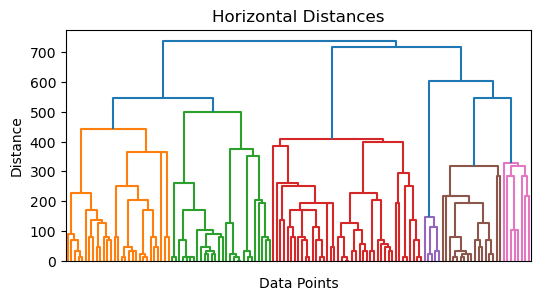

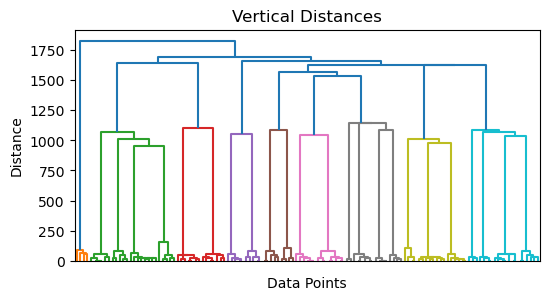

In [27]:
h = hierarchialClusteringModel()
h.plotDendrogram(horiDistPairwise,"single",title="Horizontal Distances")
h.plotDendrogram(vertDistPairwise,"single",title="Vertical Distances")

In [56]:
def scriptInputCreator(centres,coordinates,thresholdH,thresholdV):

    scriptInput = []
    for i in range(len(centres)):
        row = []
        ID = i
        TopLeft = coordinates[i,0]
        BottomRight = coordinates[i,1]
        TopEdgeCenter = [centres[i,0], TopLeft[1]]
        BottomEdgeCenter = [centres[i,0], BottomRight[1]]
        RightEdgeCenter = [BottomRight[0], centres[i,1]]
        LeftEdgeCenter = [TopLeft[0], centres[i,1]]

        TopBoxIndices = np.where(centres[:,1] > TopEdgeCenter[1])[0]
        BottomBoxIndices = np.where(centres[:,1] < BottomEdgeCenter[1])[0]
        RightBoxIndices = np.where(centres[:,0] > RightEdgeCenter[0])[0]
        LeftBoxIndices = np.where(centres[:,0] < LeftEdgeCenter[0])[0]

        # print(TopBoxIndices.shape)
        # finding nearest box in every direction
        TopBox = [np.inf, -1]
        for j in TopBoxIndices:
            d = eucDist(centres[j], centres[i])
            if (d < TopBox[0]):
                TopBox = [d, j]
        if(TopBox[0] > thresholdV): TopBox = [-1,0]

        BottomBox = [np.inf, -1]
        for j in BottomBoxIndices:
            d = eucDist(centres[j], centres[i])
            if (d < BottomBox[0]):
                BottomBox = [d, j]
        if(BottomBox[0] > thresholdV): BottomBox = [-1,0]

        RightBox = [np.inf, -1]
        for j in RightBoxIndices:
            d = eucDist(centres[j], centres[i])
            if (d < RightBox[0]):
                RightBox = [d, j]
        if(RightBox[0] > thresholdH): RightBox = [-1,0]
        
        LeftBox = [np.inf, -1]
        for j in LeftBoxIndices:
            d = eucDist(centres[j], centres[i])
            if (d < LeftBox[0]):
                LeftBox = [d, j]
        if(LeftBox[0] > thresholdH): LeftBox = [-1,0]

        row = [ID,TopLeft,BottomRight,TopEdgeCenter,BottomEdgeCenter,RightEdgeCenter,LeftEdgeCenter,TopBox,BottomBox,RightBox,LeftBox]
        scriptInput.append(np.array(row, dtype=object))
    return scriptInput

In [71]:
thresholdH = 40
thresholdV = 75
X = scriptInputCreator(centres, Coords, thresholdH, thresholdV)


In [72]:
columnNames = ["Id","Top-Left","Bottom-Right","Top","Bottom","Right","Left","Top_Box","Bottom_Box","Right_Box","Left_Box"]

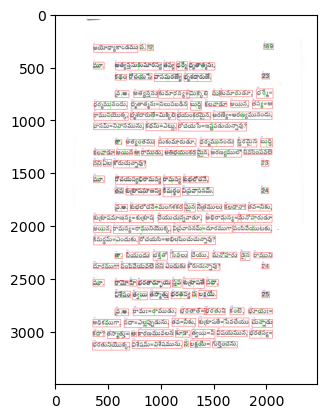

In [73]:
import matplotlib.pyplot as plt
euclidean = pd.DataFrame(data=X, columns=columnNames)
imgOut = make_connections(euclidean, img)

plt.imshow(imgOut)

### 4.3

In [16]:
import pickle
import numpy as np
with open("./bin/q4/colors.pkl", 'rb') as file:
    X = pickle.load(file)

print(X.shape)

(100, 2)


In [17]:
from sklearn.mixture import GaussianMixture

gmmModel = GaussianMixture(n_components=7)
gmmModel.fit(X)
labels = gmmModel.predict(X)

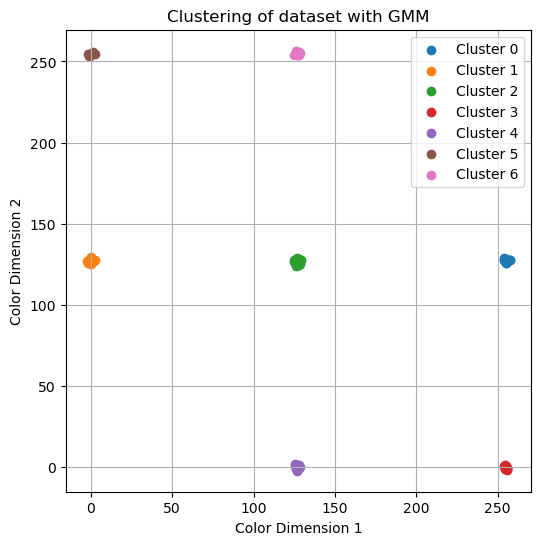

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
for cluster in range(7):
    clusterPoints = X[labels == cluster]
    plt.scatter(clusterPoints[:,0], clusterPoints[:,1], label=f'Cluster {cluster}')

plt.legend()
plt.xlabel('Color Dimension 1')
plt.ylabel('Color Dimension 2')
plt.title('Clustering of dataset with GMM')
plt.grid()
plt.show()

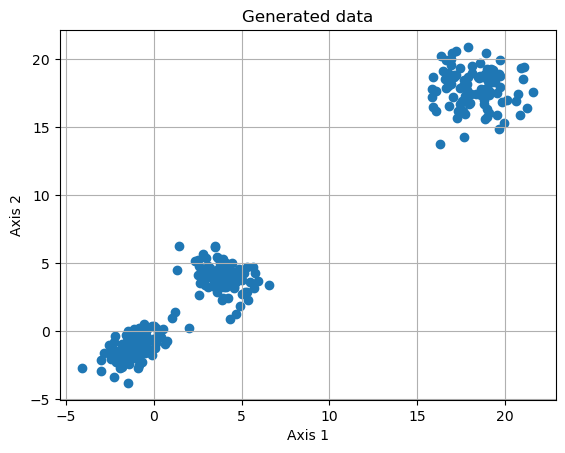

In [19]:
import numpy as np
from scipy.stats import multivariate_normal

def generate_sample_dataset(n, means, covariances, sample_size=100):
    dataset = []
    for i in range(n):
        mean = means[i]
        covariance = covariances[i]
        component_data = multivariate_normal.rvs(mean=mean, cov=covariance, size=sample_size)
        dataset.extend(component_data)
    return np.array(dataset)

n_components = 3
component_means = np.array([[-1, -1], [4, 4], [18, 18]])
component_covariances = np.array([[[1, 0.5], [0.5, 1]], [[1, -0.5], [-0.5, 1]], [[2, 0], [0, 2]]])
sample_data = generate_sample_dataset(n_components, component_means, component_covariances, sample_size=100)

import matplotlib.pyplot as plt
plt.scatter(sample_data[:,0], sample_data[:,1])

plt.xlabel('Axis 1')
plt.ylabel('Axis 2')
plt.title('Generated data')
plt.grid()
plt.show()

As it can be seen, 3 clusters of data points are obtained. If we vary the mean and coviance matrices, we can see the change in the shapes and orientation of the clusters

/home/itsmrpsycho/miniconda3/envs/coding/lib/python3.8/site-packages/scipy/stats/_multivariate.py:653: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


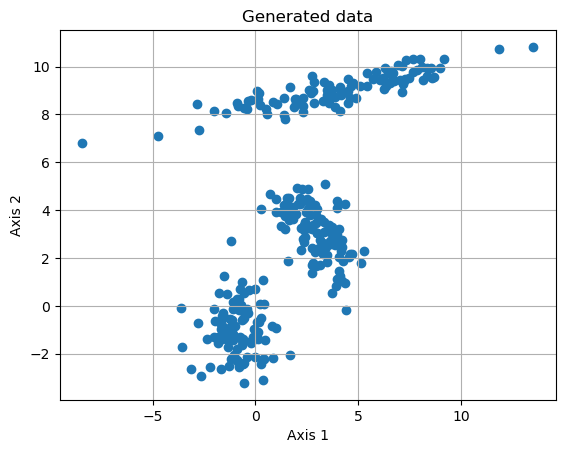

In [20]:
n_components = 3
component_means = np.array([[-1, -1], [3, 3], [4, 9]])
component_covariances = np.array([[[1, 0], [0, 1]], [[1, -0.5], [-0.5, 1]], [[11, 2], [10, 2]]])
sample_data = generate_sample_dataset(n_components, component_means, component_covariances, sample_size=100)

import matplotlib.pyplot as plt
plt.scatter(sample_data[:,0], sample_data[:,1])

plt.xlabel('Axis 1')
plt.ylabel('Axis 2')
plt.title('Generated data')
plt.grid()
plt.show()